# Deep Learning with Python and Pytorch - a quick Introduction
In this demo, we create a simplistic neural network, consisting of two fully connected linear layers and a ReLU layer, that classifies the 28x28 MNIST image dataset.

For simplicity, we do the learning stuff by using PyTorch as a black box at the beginning, but then do all forward classification manually.

We will later add a section on how exactly the learning is done.

In this notebook, you learn:

- How to define a simple network using torch
- How to learn weights for the network using torch
- How to test and apply the forward model using torch
- How to extract the weights and parameters to numpy
- How to run the forward model using your own code, giving you full control of the network
- How to interpret input layers for image classification
- Application: Use your forward code for individual pruning of the network

## Import libraries

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split,DataLoader,TensorDataset
from torchviz import make_dot
import matplotlib.pyplot as plt
import onnx
import numpy as np
from onnx import numpy_helper


### Check for GPU
We check if GPU is available.

We only use the GPU for the learning step. Just before learning, we copy the model to the gpu and then copy back.

In [ ]:
# Check if GPU is available. If yes, use it for learning.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Not working properly for me
# torch.set_default_device(device)
# torch.set_default_dtype(torch.float32)
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

## Training phase
We follow up with the complete training phase, defining parameters, loading the training data, and performing the training.

### Define parameters
- Input size for MNIST is 28x28=784
- We use 1 hidden layer with 128 neurons
- We classify into 10 classes
- We use a batch size of 100
- We use 5 iterations of the ADAM minimizer

In [ ]:
# Hyperparameter
input_size = 784  # 28x28 Bilder
hidden_size = 128
output_size = 10  # 10 Klassen für die Ziffern 0-9
num_epochs = 5
batch_size = 100
learning_rate = 0.001
test_size = 10000 # Reserve test_size images for later testing

### Define the neural network
Our Network has two linear layers connected by a ReLU.

In [ ]:
# Einfaches neuronales Netzwerk definieren
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.flatten(x)  # Bild in Vektor umwandeln
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN(input_size, hidden_size, output_size)

### Load MNIST dataset
The MNIST dataset contains 60000 images.

We train on a subset and reserve some images for later testing. Thus, we make sure that we do not test on images that were used for learning.

In [ ]:
# Datensatz laden und transformieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 1. Calculate the sizes for train/test subsets
train_size = len(full_dataset) - test_size

# 2. Use random_split to create two subsets
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# 3. Wrap them in DataLoaders if desired
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

### Show some images from the dataset
To get an idea of what the 60000 images look like, we display some random ones.

In [ ]:
# Show some images
num_images=4
images, labels = next(iter(test_loader))  # Get a batch of test data
# Convert images to numpy for visualization
images = images.numpy()
fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')  # Display the image
        ax.set_title(f'T: {labels[i].item()}',fontsize=30)  # Predictions and true labels
        ax.axis('off')
plt.tight_layout()
plt.show()


### Perform training and miminization
We use CrossEntropy for Loss and Adam as minimizer.

Cross Entropy is often used for integer outputs and defined as
$$
\ell(\mathbf{x}, k)
= -\log \Biggl( \frac{\exp(x_k)}{\displaystyle \sum_{j=1}^{N} \exp(x_j)} \Biggr)
= -\,x_k \;+\; \log \Biggl(\sum_{j=1}^{N} \exp(x_j)\Biggr),
$$

In this, $k$ is the true value and $x$ is the output delivered by the network. For a batch of samples, this is averaged over all samples (or summed up, equivalently).

The Adam-Minimizer is a weighted gradient descent minimization strategy, defined as

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1)\,g_t,\\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2)\,g_t^2,\\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t}, 
\quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t},\\
\theta_{t+1} &= \theta_t - \alpha \,\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon},
\end{aligned}
$$

where

$$
\begin{aligned}
g_t &: \text{gradient of the loss w.r.t. } \theta_t,\\
\alpha &: \text{learning rate},\\
\beta_1, \beta_2 &: \text{exponential decay rates for the moving averages of } m_t, v_t,\\
\varepsilon &: \text{small constant for numerical stability}.
\end{aligned}
$$

The exact program is given in https://pytorch.org/docs/stable/generated/torch.optim.Adam.html. The initial values for all parameters are printed out. It seems that they are not changed in the run of the program.

In [ ]:
# Verlustfunktion und Optimierer
model=model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer)

# Training des Modells
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Vorwärtsdurchlauf
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        
        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Schritt [{i+1}/{len(train_loader)}], Verlust: {loss.item():.4f}')

model=model.to('cpu')

print("Training abgeschlossen.")

### Export the network
We later want to analyze the network, export as ONNX and png.

In [ ]:
# Export network to model.onnx and model_architecture.png
# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 1, 28, 28)  # Batch size of 1, 1 channel, 28x28 image

# Perform a forward pass to obtain the model's output
output = model(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the diagram to a file
dot.format = 'png'
dot.render('model_architecture')

dummy_input = torch.randn(1, 1, 28, 28)  # Adjust dimensions as needed
torch.onnx.export(model, dummy_input, "model.onnx")

Load the ONNX file model.onnx into https://netron.app/ to receive this representation. Note that the ONNX contains all data of the network, including weights and initializers.

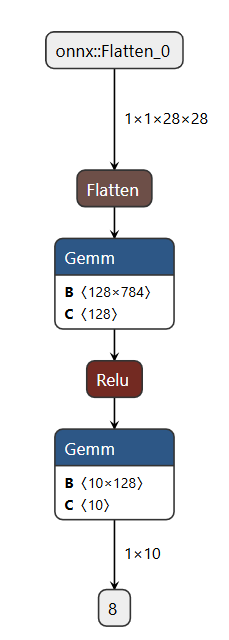

### Some test images
Now finally, some test images together with their predictions. P is Prediction, T is True. First row is from the training dataset, second row is from the test dataset.

In [ ]:
# Function to display a batch of images with predictions and true labels
def show_predictions(model, test_loader, num_images=10):
    model.eval()  # Ensure the model is in evaluation mode
    images, labels = next(iter(test_loader))  # Get a batch of test data
    outputs = model(images)  # Get predictions
    _, predictions = torch.max(outputs, 1)  # Extract the class with the highest score
    
    # Convert images to numpy for visualization
    images = images.numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')  # Display the image
        ax.set_title(f'P: {predictions[i].item()} | T: {labels[i].item()}',fontsize=30)  # Predictions and true labels
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, train_loader, num_images=4)
show_predictions(model, test_loader, num_images=4)

## Manual forward model
In order to get a better insight into the model, we now turn away from Pytorch. We load the ONNX model, extract the network parameters and run everything in plain.

We start by loading the ONNX model.

### Load ONNX model


In [ ]:
# Load the ONNX model
def read_onnx_model(onnx_file):
    # Load ONNX model
    model = onnx.load(onnx_file)
    onnx.checker.check_model(model)
    print(f"Model {onnx_file} loaded successfully.")
    return model
def extract_model_info(onnx_model):
    # Get graph from the model
    graph = onnx_model.graph
    layers = {node.name: node for node in graph.node}
    input_tensors = {input.name: input for input in graph.input}
    output_tensors = {output.name: output for output in graph.output}
    initializers = {initializer.name: initializer for initializer in graph.initializer}
    return layers, input_tensors, output_tensors, initializers

def print_onnx_info(onnx_model):
    # Load ONNX model
    model = onnx_model
    onnx.checker.check_model(model)
    print(f"Model {onnx_file} loaded successfully.\n")

    # Get the graph
    graph = model.graph

    # Print inputs
    print("== Model Inputs ==")
    for input_tensor in graph.input:
        dims = [d.dim_value if d.dim_value > 0 else "?" for d in input_tensor.type.tensor_type.shape.dim]
        print(f"Name: {input_tensor.name}, Type: {input_tensor.type.tensor_type.elem_type}, Shape: {dims}")

    # Print outputs
    print("\n== Model Outputs ==")
    for output_tensor in graph.output:
        dims = [d.dim_value if d.dim_value > 0 else "?" for d in output_tensor.type.tensor_type.shape.dim]
        print(f"Name: {output_tensor.name}, Type: {output_tensor.type.tensor_type.elem_type}, Shape: {dims}")

    # Print initializers
    print("\n== Model Initializers ==")
    for initializer in graph.initializer:
        dims = initializer.dims
        print(f"Name: {initializer.name}, Type: {initializer.data_type}, Shape: {dims}")

    # Print nodes (operations)
    print("\n== Model Nodes ==")
    for node in graph.node:
        print(f"Operation: {node.op_type}, Name: {node.name}")
        print(f"  Inputs: {', '.join(node.input)}")
        print(f"  Outputs: {', '.join(node.output)}")

    # Print value info (additional tensor details)
    print("\n== Additional Tensor Info ==")
    for value_info in graph.value_info:
        dims = [d.dim_value if d.dim_value > 0 else "?" for d in value_info.type.tensor_type.shape.dim]
        print(f"Name: {value_info.name}, Type: {value_info.type.tensor_type.elem_type}, Shape: {dims}")

onnx_file = "model.onnx"  # Replace with your ONNX file path
onnx_model = read_onnx_model(onnx_file)
layers, input_tensors, output_tensors, initializers = extract_model_info(onnx_model)
print_onnx_info(onnx_model)

## Modeling the prediction step
Our simple model has only two types of network nodes. Relu and Gemm. 

The ReLU transfer function is simply defined as
$$
\operatorname{ReLU}(x) = \max(0, x)
$$
where $x$ is a vector and the max is taken componentwise.

For Gemm, we have $$
\mathbf{Y} 
= \alpha \Bigl(
  \underbrace{
    \begin{cases}
      \mathbf{A}^\top & \text{if }\text{transA} = 1,\\
      \mathbf{A}      & \text{otherwise}
    \end{cases}
  }_{\tilde{\mathbf{A}}}
  \;\times\;
  \underbrace{
    \begin{cases}
      \mathbf{B}^\top & \text{if }\text{transB} = 1,\\
      \mathbf{B}      & \text{otherwise}
    \end{cases}
  }_{\tilde{\mathbf{B}}}
\Bigr)
\;+\;
\beta\,\mathbf{C},
$$

where 
$$
\tilde{\mathbf{A}} \in \mathbb{R}^{m \times k}, 
\quad
\tilde{\mathbf{B}} \in \mathbb{R}^{k \times n}, 
\quad
\mathbf{C} \in \mathbb{R}^{m \times n},
\quad
\alpha,\beta \in \mathbb{R},
$$
and 
$\tilde{\mathbf{A}}$ (resp. $\tilde{\mathbf{B}}$) denotes $\mathbf{A}$ (resp. $\mathbf{B}$) possibly transposed based on the attributes $\text{transA}$ and $\text{transB}$. The operator $\times$ is standard matrix multiplication.

That lets us define the forward model run. Note that this is not general, it is taylormade for our network, take are when applying it to networks of different structure.

In [ ]:
# define a custom run function
def run_model(layers, initializers, input_data):
    # Parse initializers into numpy arrays
    weights = {}
    for name, initializer in initializers.items():
        weights[name] = np.frombuffer(initializer.raw_data, dtype=np.float32).reshape(tuple(initializer.dims))

    # Simulate forward pass manually
    data = input_data
    for layer_name, layer in layers.items():
        inputs = [data[input_name] if input_name in data else weights[input_name] for input_name in layer.input]
        if layer.op_type == "Gemm":
            # Fully connected layer (matrix multiplication + bias)
            A, B, C = inputs  # A: input, B: weights, C: bias
            alpha = float(next((attr.f for attr in layer.attribute if attr.name == "alpha"), 1.0))
            beta = float(next((attr.f for attr in layer.attribute if attr.name == "beta"), 1.0))
            transA = int(next((attr.i for attr in layer.attribute if attr.name == "transA"), 0))
            transB = int(next((attr.i for attr in layer.attribute if attr.name == "transB"), 0))
            
            if transA:
                A = A.T
            if transB:
                B = B.T
            
            output = alpha * np.dot(A, B) + beta * C
            data[layer.output[0]] = output

        elif layer.op_type == "Relu":
            # Rectified Linear Unit activation
            A = inputs[0]
            output = np.maximum(0, A)
            data[layer.output[0]] = output
        
        elif layer.op_type == "Flatten":
            # Flatten the input tensor
            A = inputs[0]
            axis = int(next((attr.i for attr in layer.attribute if attr.name == "axis"), 1))
            output = A.reshape(A.shape[0], -1)
            data[layer.output[0]] = output

        else:
            raise NotImplementedError(f"Layer type {layer.op_type} not implemented.")

    return data

### Compare our forward run and Pytorch
We check that our simple forward model and pytorch give the same results. Note that the strange name '8' for the output layer comes from ONNX and is given in the image above.

In [ ]:
# compare the models
def compare_models(onnx_layers,onnx_initializers, pytorch_model, test_loader, num_images=10):
    diff=0
    onnx_correct=0
    pytorch_correct=0
    pytorch_model.eval()
    for imagesvec, labelsvec in test_loader:
      for i,images in enumerate(imagesvec):
        label=labelsvec[i]
        outputs_pytorch = model(images)[0].detach().numpy()
        images_data = images.view(1, -1).numpy()  # Flatten the image
        data = {next(iter(input_tensors)): images_data}
        outputs_onnx=run_model(onnx_layers,onnx_initializers,data)
        outputs_onnx=outputs_onnx['8'][0]
        diff=diff+np.linalg.norm(outputs_onnx-outputs_pytorch)
        label_onnx=np.argmax(outputs_onnx)
        label_pytorch=np.argmax(outputs_pytorch)
        if (label==label_onnx):
            onnx_correct=onnx_correct+1
        if (label==label_pytorch):
            pytorch_correct=pytorch_correct+1
    print('Average difference: ',diff/len(test_loader)/batch_size)
    print('Ratio of correct labels for onnx: ',onnx_correct/(len(test_loader)*batch_size)*100)
    print('Ratio of correct labels for Pytorch: ',pytorch_correct/(len(test_loader)*batch_size)*100)

compare_models(layers,initializers,model,test_loader)
compare_models(layers,initializers,model,train_loader)

## Understanding the weights
Let us now investigate the first Gemm node and try to understand it. For the major part, this is just matrix multiplication of the input tensor A and the weights matrix B (note that this is stored transposed). 

Matrix multiplication can be thought of as taking the scalar product of each row of A with every column of B (again, note that these columns are stored as rows). Due to Cauchy-Schwartz, this scalar product is maximal when one row is generated from the other by multiplying with a positive factor. Remembering that the input is an image, the columns of B can be interpreted as prototype images or features.

So, the scalar product can be interpreted as a very simple similarity measurement. When the scalar product is large, the similarity between image and feature is high. When it is very small (negative), the similarity is also large, but reversed (black and white interchanged).

Using this interpretation, we can easily understand what is going on here. In the first Gemm, we have 128 images for which a similarity measurement towards the input is taken. The ReLU then cuts off the reverse similarity (ignoring the bias here). The second Gemm network then decides which features are characteristic for a number and assigns an importance weight to it.

We now test this hypothesis first by displaying the columns of B as images.

### Visualize the columns of first weight

In [ ]:
# Extract weights and visualize the columns
def extract_weights(onnx_model, layer_name=None):
    # Get graph from the model
    graph = onnx_model.graph
    initializers = {initializer.name: initializer for initializer in graph.initializer}

    # Find the weight matrix for the specified layer (e.g., first GEMM layer)
    if layer_name is None:
        layer_name = list(initializers.keys())[0]  # Default to the first initializer if none specified
    print(f"Using {layer_name}")
    
    weight_initializer = initializers[layer_name]
    weights = np.frombuffer(weight_initializer.raw_data, dtype=np.float32).reshape(tuple(weight_initializer.dims))
    return weights

def visualize_weights(weights, input_size, num_classes, images_per_row=7, save_path=None):
    """
    Visualize the weights as prototype images.

    :param weights: Weight matrix to visualize (classes x features)
    :param input_size: Flattened input size (e.g., 784 for MNIST)
    :param num_classes: Number of classes to visualize
    :param images_per_row: Number of images to display per row
    :param save_path: Path to save the visualization (optional)
    """
    img_shape = (int(np.sqrt(input_size)), int(np.sqrt(input_size)))
    assert np.prod(img_shape) == input_size, "Input size does not match expected image dimensions."

    # Normalize the weights for better visualization
    normalized_weights = (weights - np.min(weights, axis=1, keepdims=True)) / \
                         (np.max(weights, axis=1, keepdims=True) - np.min(weights, axis=1, keepdims=True))

    # Determine number of rows and columns
    rows = (num_classes + images_per_row - 1) // images_per_row
    cols = min(images_per_row, num_classes)

    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if rows > 1 else [axes]

    # Plot each class's weights
    for i in range(num_classes):
        ax = axes[i]
        img = normalized_weights[i].reshape(img_shape)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Row {i}",fontsize=30)
        ax.axis("off")

    # Turn off unused subplots
    for j in range(num_classes, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

weights = extract_weights(onnx_model,layer_name="fc1.weight")

# Define MNIST-specific parameters
input_size = weights.shape[1]  # Flattened size of the input
num_classes = weights.shape[0]  # Number of output classes
if (input_size!=784):
    input_size, num_classes=num_classes, input_size
    weights=weights.T
# Visualize weights as prototype images
visualize_weights(weights, input_size, num_classes, images_per_row=7)


### Interpreting the images
We see that mostly, our interpretation was correct. Many columns represent prototype images or features that are in some way contained in the images. We will come back to this later.

However, many images just contain noise. They obviously provide no usable information at all. In fact, we should remove these from the model, since they obviously only give fake information.

This removal process is called pruning, we will do this manually later. However, pruning is integrated into all major software packages, particularly pytorch.

### Checking the most important features
We now take a random image from the set and try to understand how it was classified. To do this, we run the image through the simulated network. Then, we take the output of the ReLU node and examine the application of weights B.
We start by computing the output value for a random image. Note that since the image is always different, you have to interpret yourself what you see.

In [ ]:
# Importance check
input_tensor=next(iter(input_tensors))
B=extract_weights(onnx_model,'fc2.weight')
bias=extract_weights(onnx_model,'fc2.bias')
B=B.transpose()
images_vec,labels_vec=next(iter(test_loader))
image=images_vec[0]
label=labels_vec[0].numpy()
input_data = image.view(1, -1).numpy()  # Flatten the image
data={input_tensor:input_data}
result=run_model(layers, initializers, data)
arr=result['8'][0]
print(f'Correct index is {label}\n')
# 1. Get indices that would sort arr by descending magnitude
sorted_indices = np.argsort((arr))[::-1]

# 2. Print the result as index:value pairs
for idx in sorted_indices:
    print(f"{idx}:{arr[idx]}")

We do the last step again manually using B and bias.

In [ ]:
# Compute results in numpy
relu_output=result['/relu/Relu_output_0'][0]
manually=relu_output.dot(B)+bias
arr=manually
# 1. Get indices that would sort arr by descending magnitude
sorted_indices = np.argsort((arr))[::-1]
# 2. Print the result as index:value pairs
for idx in sorted_indices:
    print(f"{idx}:{arr[idx]}")

Ok, so our interpretation is correct. Now we go deeper. Since the bias in this case is more or less negligible, we do exactly that.


In [ ]:
# Compute top contributing features for each output
def largest_contributors_sorted_by_output(a, B, top_n=3):
    """
    a: shape (128,)
    B: shape (128, 10)
    top_n: number of top contributors for each output dimension.

    Returns a list of dictionaries, one per output dimension, in descending order
    of the output value. Each dictionary has:
      - "output_index": int, the index of this output dimension
      - "output_value": float, the computed y[output_index]
      - "top_contributors": list of (index, contribution) sorted by descending contribution
    """
    # 1. Compute the output vector y = a @ B -> shape: (10,)
    y = a @ B
    
    # 2. Sort outputs by descending value
    sorted_output_indices = np.argsort(y)[::-1]
    
    results = []
    
    # 3. For each output dimension in descending order
    for out_idx in sorted_output_indices:
        # partial_products[k] = a[k] * B[k, out_idx]
        partial_products = a * B[:, out_idx]
        
        # Sort partial products in descending order
        sorted_indices = np.argsort(partial_products)[::-1]
        top_indices = sorted_indices[:top_n]
        
        # Build a list of (index, contribution)
        top_list = [(int(idx), float(partial_products[idx])) for idx in top_indices]
        
        # Collect result in a dictionary
        results.append({
            "output_index": int(out_idx),
            "output_value": float(y[out_idx]),
            "top_contributors": top_list
        })

    for elem in results:
        out_idx = elem["output_index"]
        out_val = elem["output_value"]
        top_list = elem["top_contributors"]
        
        # One-line output: output index, value, top contributors
        contributors_str = ", ".join(f"{idx}:{val:.4f}" for idx, val in top_list)
        print(f"y[{out_idx}] = {out_val:.4f}, top {len(top_list)} => {contributors_str}")

    return results

contribs = largest_contributors_sorted_by_output(relu_output, B, top_n=5)

    # Example of how you might print the condensed result


Now take the image of the top contributor for your image. In my test, this is really close to a 5 which was the correct answer. Do this several times, and you get a feeling for it. To make this easier, we display the original image, and the top two contributors.

Note that we ignored the bias, so the results are slightly off.

In [ ]:
# Show top contributors visually
import numpy as np
import matplotlib.pyplot as plt

def show_four_images_side_by_side(vec1, vec2, vec3, vec4,
                                  title1="Image 1", 
                                  title2="Image 2", 
                                  title3="Image 3", 
                                  title4="Image 4"):
    """
    Each vecX is assumed to be a 1D numpy array of length 784 (28x28).
    Displays them side by side with given titles.
    """
    # Reshape each vector into 28x28
    img1 = vec1.reshape(28, 28)
    img2 = vec2.reshape(28, 28)
    img3 = vec3.reshape(28, 28)
    img4 = vec4.reshape(28, 28)
    
    # Create subplots: 1 row, 4 columns
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
    
    # Display each image in grayscale
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(title1,fontsize=30)
    axes[0].axis("off")  # Hide axis ticks
    
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(title2,fontsize=30)
    axes[1].axis("off")
    
    axes[2].imshow(img3, cmap='gray')
    axes[2].set_title(title3,fontsize=30)
    axes[2].axis("off")
    
    axes[3].imshow(img4, cmap='gray')
    axes[3].set_title(title4,fontsize=30)
    axes[3].axis("off")
    
    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

# Example usage with dummy data:
im=image.numpy()
top1=contribs[0]['top_contributors'][0][0]
top2=contribs[1]['top_contributors'][1][0]
top3=contribs[2]['top_contributors'][2][0]
show_four_images_side_by_side(im,weights[top1,:],weights[top2,:],weights[top3,:],
                             'Image','Top 1','Top 2','Top 3')

Note that this interpretation is very far from perfect. In particular, one needs to adress also the other elements. It is not only that one class is chosen as superior, but it might also be that just all other classes are impossible.

## Pruning results
We already noticed that some of the internal notes seem to contribute only noise to the classification. In a pruning step, nodes that do not contribute or are bad contributors are removed from the network.
In our simple network, the approach is simple. We analyze the columns of the first weight matrix. If these are random and not images, we delete them from the network.
Alternatively, one could try to estimate what the contribution of each node to the result is, possibly by running a large test data set, and then remove the N most irrelevant nodes.
We use both approaches. In the first one, we measure the "imageness" of the rows and remove the N most unlikely images.
In the second, we try to estimate the relevance of a node by looking at the weight matrix. The results are mostly the same.

### Pruning approach 1: Measure imageness
In this approach, we estimate the covariance of adjacent pixels in the image (very crude approach). Then, we remove the nodes that correspond to non-images.

Note that this can be interpreted as taking the scalar product of the original image and one that was shifted one pixel up/down (see the feature discussion above).

We work directly on the ONNX files.

In [ ]:
# Prune by imageness
def measure_imageness(row_vector, img_height=28, img_width=28):
    """
    Given a 1D row_vector representing a flattened 2D image (28x28),
    compute a simple “image-likeness” score.
    For demonstration, we sum the products of horizontally and vertically
    adjacent pixels. Larger values => more structured, less random/noisy.
    """
    # Reshape the row into a 2D image
    img = row_vector.reshape(img_height, img_width)

    score = 0.0
    # Horizontal neighbors
    for i in range(img_height):
        for j in range(img_width - 1):
            score += img[i, j] * img[i, j+1]

    # Vertical neighbors
    for i in range(img_height - 1):
        for j in range(img_width):
            score += img[i, j] * img[i+1, j]

    return score

def prune_noisy_neurons(
    model_path: str,
    output_path: str,
    num_to_remove: int = 45,
    img_height: int = 28,
    img_width: int = 28,
    fc1_weight_name: str = "fc1.weight",
    fc1_bias_name: str = "fc1.bias",
    fc2_weight_name: str = "fc2.weight",
    fc2_bias_name: str = "fc2.bias"
) -> onnx.ModelProto:
    """
    Load an ONNX model and prune rows (neurons) of fc1.weight that appear
    to be "noisy" when interpreted as a 28x28 image. By default, removes 45 neurons.
    """

    # 1. Load the ONNX model
    model = onnx.load(model_path)
    graph = model.graph

    # Helper function: retrieve initializer by name
    def get_param(name):
        for init in graph.initializer:
            if init.name == name:
                return init
        raise ValueError(f"Initializer '{name}' not found in the model.")

    # 2. Extract initializers as NumPy arrays
    fc1_weight_init = get_param(fc1_weight_name)
    fc1_bias_init   = get_param(fc1_bias_name)
    fc2_weight_init = get_param(fc2_weight_name)
    fc2_bias_init   = get_param(fc2_bias_name)

    fc1_weight = numpy_helper.to_array(fc1_weight_init)  # shape: (hidden_size, 784)
    fc1_bias   = numpy_helper.to_array(fc1_bias_init)    # shape: (hidden_size,)
    fc2_weight = numpy_helper.to_array(fc2_weight_init)  # shape: (output_size, hidden_size)
    fc2_bias   = numpy_helper.to_array(fc2_bias_init)    # shape: (output_size,)

    # Check that each row has length = 28*28
    hidden_size, in_features = fc1_weight.shape
    expected_size = img_height * img_width
    if in_features != expected_size:
        raise ValueError(
            f"Expected fc1_weight to have {expected_size} in_features, "
            f"but got shape {fc1_weight.shape}."
        )

    # 3. Compute an “image-likeness” score for each row (neuron)
    scores = []
    for row_idx in range(hidden_size):
        row_vector = fc1_weight[row_idx, :]  # shape [784]
        score = measure_imageness(row_vector, img_height, img_width)
        scores.append(score)

    scores = np.array(scores)

    # 4. Identify the neurons with the lowest scores => "noisy"
    if num_to_remove >= hidden_size:
        raise ValueError(f"Cannot remove {num_to_remove} neurons from only {hidden_size}.")
    sorted_indices = np.argsort(scores)  # ascending order
    remove_indices = sorted_indices[:num_to_remove]
    keep_indices   = sorted_indices[num_to_remove:]

    # 5. Prune from fc1_weight, fc1_bias, fc2_weight
    #    - Removing neurons => remove those rows in fc1_weight
    #    - fc1_bias => remove the same entries
    #    - fc2_weight => remove corresponding columns
    pruned_fc1_weight = fc1_weight[keep_indices, :]
    pruned_fc1_bias   = fc1_bias[keep_indices]
    # fc2_weight shape: (output_size, hidden_size)
    # removing neurons => remove same columns
    pruned_fc2_weight = fc2_weight[:, keep_indices]

    # fc2_bias remains unchanged (size = output_size)

    # 6. Update the initializers
    def set_param(param_init, new_array):
        new_tensor = numpy_helper.from_array(new_array, param_init.name)
        param_init.ClearField("float_data")
        param_init.ClearField("int32_data")
        param_init.ClearField("int64_data")
        param_init.raw_data = new_tensor.raw_data
        param_init.dims[:] = new_array.shape

    set_param(fc1_weight_init, pruned_fc1_weight)
    set_param(fc1_bias_init,   pruned_fc1_bias)
    set_param(fc2_weight_init, pruned_fc2_weight)
    # fc2_bias unchanged

    # 7. Save the pruned model
    onnx.save(model, output_path)
    print(f"Pruned {num_to_remove} ‘noisy’ neurons. Saved to '{output_path}'.")
    return model

prune_model_1=prune_noisy_neurons(
        model_path="model.onnx",
        output_path="model_pruned_imageness.onnx",
        num_to_remove=48  # default
    )


We print out the model and compare.

Note that the number of neurons in the hidden layewr has been reduced to 80, but the success rates do not change.

In [ ]:
# Display parameters of pruned model
prune_layers, prune_input_tensors, prune_output_tensors, prune_initializers = extract_model_info(prune_model_1)
print_onnx_info(prune_model_1)

In [ ]:
# compare fully connected and imageness
print('fully connected model')
compare_models(layers,initializers,model,test_loader)
print('imageness pruned model')
compare_models(prune_layers,prune_initializers,model, test_loader)

### Pruning approach 2: estimate relevance
In this approach, we simply add up the contributing weights for each neuron in the hidden layer and remove those with the smalles weights. 

In [ ]:
# Prune by weight
def prune_hidden_neurons(
    model_path: str,
    output_path: str,
    n_to_prune: int
) -> onnx.ModelProto:
    """
    Load an ONNX model, prune N neurons from the hidden layer, 
    and save the pruned model to output_path.
    Returns the pruned model object.
    """

    # 1. Load ONNX model
    model = onnx.load(model_path)
    graph = model.graph

    # 2. Identify weight/bias initializers for fc1 and fc2.
    #    Change these names if your ONNX export uses different ones.
    fc1_weight_name = "fc1.weight"
    fc1_bias_name   = "fc1.bias"
    fc2_weight_name = "fc2.weight"
    fc2_bias_name   = "fc2.bias"

    # Helper function to grab an initializer's numpy array
    def get_param(name):
        for init in graph.initializer:
            if init.name == name:
                return init
        raise ValueError(f"Initializer {name} not found in the model.")

    # 3. Convert the relevant initializers to numpy arrays
    fc1_weight_init = get_param(fc1_weight_name)
    fc1_bias_init   = get_param(fc1_bias_name)
    fc2_weight_init = get_param(fc2_weight_name)
    fc2_bias_init   = get_param(fc2_bias_name)

    fc1_weight = numpy_helper.to_array(fc1_weight_init)  # shape [hidden_size, input_size]
    fc1_bias   = numpy_helper.to_array(fc1_bias_init)    # shape [hidden_size]
    fc2_weight = numpy_helper.to_array(fc2_weight_init)  # shape [output_size, hidden_size]
    fc2_bias   = numpy_helper.to_array(fc2_bias_init)    # shape [output_size]

    # Sanity check
    hidden_size = fc1_bias.shape[0]
    if n_to_prune >= hidden_size:
        raise ValueError(f"Cannot prune {n_to_prune} neurons from hidden layer of size {hidden_size}.")

    # 4. Compute saliency measure for each hidden neuron
    #    Here, "saliency" = sum(|fc1_weight[i, :]|) + sum(|fc2_weight[:, i]|)
    saliencies = (
        # np.abs(fc1_weight).sum(axis=1)  # row i in fc1 (for hidden neuron i)
        np.abs(fc2_weight).sum(axis=0)  # column i in fc2
    )

    # 5. Identify the neurons with the smallest saliency
    prune_indices = np.argsort(saliencies)[:n_to_prune]
    print(prune_indices)
    print(saliencies[prune_indices])
    keep_indices = [i for i in range(hidden_size) if i not in prune_indices]

    # 6. Construct new pruned arrays
    pruned_fc1_weight = fc1_weight[keep_indices, :]
    pruned_fc1_bias   = fc1_bias[keep_indices]
    pruned_fc2_weight = fc2_weight[:, keep_indices]
    # fc2_bias is unchanged because it's [output_size] (no hidden-dim index)

    # 7. Update the initializers in the graph
    def set_param(param_init, new_array):
        new_tensor = numpy_helper.from_array(new_array, param_init.name)
        # Clear out the existing data fields
        param_init.ClearField("float_data")
        param_init.ClearField("int32_data")
        param_init.ClearField("int64_data")
        # Assign the new raw_data and dimensions
        param_init.raw_data = new_tensor.raw_data
        param_init.dims[:] = new_array.shape

    set_param(fc1_weight_init, pruned_fc1_weight)
    set_param(fc1_bias_init,   pruned_fc1_bias)
    set_param(fc2_weight_init, pruned_fc2_weight)
    # fc2_bias remains as is

    # 8. (Optional) Update shape info if your model has static shapes.
    #    Here, we skip it, letting shape inference happen at runtime.

    # 9. Save the pruned model
    onnx.save(model, output_path)

    return model

prune_model_2 = prune_hidden_neurons(
        model_path="model.onnx",
        output_path="model_pruned_magnitude.onnx",
        n_to_prune=48  # number of neurons to remove from hidden layer
    )


Analyze as above.

In [ ]:
# print model info
prune_layers2, prune_input_tensors2, prune_output_tensors2, prune_initializers2 = extract_model_info(prune_model_2)
print_onnx_info(prune_model_2)

In [ ]:
# Compare all models
print('fully connected model')
compare_models(layers,initializers,model,test_loader)
print('pruned by imageness')
compare_models(prune_layers,prune_initializers,model, test_loader)
print('pruned by weight')
compare_models(prune_layers2,prune_initializers2,model, test_loader)

Finally, we check that we removed the correct nodes from the set.

In [ ]:
# Show imageness pruned weights
weights_prune = extract_weights(prune_model_1)
# Define MNIST-specific parameters
input_size = weights_prune.shape[1]  # Flattened size of the input
num_classes = weights_prune.shape[0]  # Number of output classes

# Visualize weights as prototype images
visualize_weights(weights_prune, input_size, num_classes, images_per_row=7)


In [ ]:
# Show weights pruned images
weights_prune = extract_weights(prune_model_2)
# Define MNIST-specific parameters
input_size = weights_prune.shape[1]  # Flattened size of the input
num_classes = weights_prune.shape[0]  # Number of output classes

# Visualize weights as prototype images
visualize_weights(weights_prune, input_size, num_classes, images_per_row=7)


We see that the imageness approach worked, while the magnitude approach left two noise images in the network (and removed two relevant ones). However, the success range hardly changed. Again, since everything in here is completely random, your mileage may vary when running the notebook.

## Gradient computation
We now investigate how the weights are learned. Again, we switch to our simple model from the beginning. First thing, we need to define gradient computation for the network.

### Simplify ONNX model
We start by simplifying the ONNX model by explicitly transposing the internal B matrices of the GEMM nodes, so now transB and transA are always false. We can leave them out in the following.

In [ ]:
import onnx
import numpy as np
from collections import defaultdict
from onnx import numpy_helper

# Load the ONNX model
onnx_model = onnx.load('model.onnx')

# Function to normalize GEMM nodes by transposing weights if transB is True
def normalize_gemm_nodes(model):
    """
    Normalize the GEMM nodes in the ONNX model by transposing weight matrices
    where transB is set to True, and setting transB to False.

    Parameters:
    - model: The ONNX model to be normalized.

    Returns:
    - normalized_model: The normalized ONNX model.
    """
    graph = model.graph

    # Helper function to find an initializer by name
    def find_initializer(name):
        for initializer in graph.initializer:
            if initializer.name == name:
                return initializer
        return None

    # Iterate over all nodes in the graph
    for node in graph.node:
        if node.op_type == 'Gemm':
            # Check for the transB attribute
            transB_attr = next((attr for attr in node.attribute if attr.name == 'transB'), None)
            transB = transB_attr.i if transB_attr else 0

            if transB == 1:
                # Find the weight initializer (second input of Gemm)
                weight_name = node.input[1]
                weight_initializer = find_initializer(weight_name)

                if weight_initializer:
                    # Convert the initializer to a numpy array
                    weight_array = numpy_helper.to_array(weight_initializer)

                    # Transpose the weight array
                    transposed_weight_array = weight_array.T

                    # Create a new initializer with the transposed weights
                    new_weight_initializer = numpy_helper.from_array(transposed_weight_array, name=weight_name)

                    # Replace the old initializer with the new one
                    graph.initializer.remove(weight_initializer)
                    graph.initializer.append(new_weight_initializer)

                    # Set transB to 0 (False)
                    transB_attr.i = 0

    return model

# Normalize the GEMM nodes
onnx_model = normalize_gemm_nodes(onnx_model)

# Save the normalized model if needed
onnx.save(onnx_model, 'normalized_model.onnx')


### Forward and backward pass
The forward pass is the same as above, only this time we leave out transB etc. Also, we allow for the input to be a tensor (batch of images).

In the backward pass, we compute the gradient of the loss function according to the chain rule. We obviously have

$$
\frac{d}{db} f_1(a,f_2(b,x))=(f_1)_y(a,f_2(b,x))\cdot (f_2)_x(b,x)
$$

In [ ]:

def gemm_forward(A, B, C=None, alpha=1.0, beta=1.0):
    """
    Perform the forward pass of the GEMM operation for a batch of inputs.

    Parameters:
    - A: Input tensor of shape (N, input_features).
    - B: Weight matrix of shape (input_features, output_features).
    - C: Bias vector of shape (output_features,) or None.
    - alpha: Scalar multiplier for the product of A and B.
    - beta: Scalar multiplier for the bias C.

    Returns:
    - Y: Output tensor of shape (N, output_features).
    """
    Y = alpha * np.dot(A, B)
    if C is not None:
        Y += beta * C
    return Y

def gemm_backward(dY, A, B, C, alpha=1.0, beta=1.0):
    """
    Compute the gradients of the GEMM operation with respect to A, B, and C for a batch of inputs.

    Parameters:
    - dY: Gradient of the loss with respect to the output Y, shape (N, output_features).
    - A: Input tensor of shape (N, input_features).
    - B: Weight matrix of shape (input_features, output_features).
    - alpha: Scalar multiplier for the product of A and B.
    - beta: Scalar multiplier for the bias C.

    Returns:
    - dA: Gradient with respect to A, shape (N, input_features).
    - dB: Gradient with respect to B, shape (input_features, output_features).
    - dC: Gradient with respect to C, shape (output_features,).
    """
    dA = alpha * np.dot(dY, B.T)
    dB = alpha * np.dot(A.T, dY)
    dC = beta * np.sum(dY, axis=0) if beta != 0 else None
    return dA, dB, dC

def relu_forward(X):
    """
    Perform the forward pass of the ReLU activation function for a batch of inputs.

    Parameters:
    - X: Input tensor of shape (N, features).

    Returns:
    - Y: Output tensor after applying ReLU, same shape as X.
    """
    return np.maximum(0, X)

def relu_backward(dY, X):
    """
    Compute the gradient of the ReLU activation function with respect to its input for a batch of inputs.

    Parameters:
    - dY: Gradient of the loss with respect to the output of the ReLU layer, shape (N, features).
    - X: Input to the ReLU layer, shape (N, features).

    Returns:
    - dX: Gradient of the loss with respect to the input of the ReLU layer, same shape as X.
    """
    return dY * (X > 0)

def flatten_forward(X, axis=1):
    """
    Perform the forward pass of the Flatten operation for a batch of inputs.

    Parameters:
    - X: Input tensor of shape (N, ...).
    - axis: The axis to flatten from.

    Returns:
    - Y: Flattened output tensor of shape (N, new_features).
    - original_shape: The original shape of the input tensor.
    """
    original_shape = X.shape
    new_shape = (original_shape[0], -1)
    Y = X.reshape(new_shape)
    return Y, original_shape

def flatten_backward(dY, original_shape):
    """
    Compute the gradient of the Flatten operation with respect to its input for a batch of inputs.

    Parameters:
    - dY: Gradient of the loss with respect to the flattened output, shape (N, new_features).
    - original_shape: The original shape of the input tensor before flattening.

    Returns:
    - dX: Gradient of the loss with respect to the input of the Flatten layer, shape same as original_shape.
    """
    return dY.reshape(original_shape)

In [ ]:
# Forward and backward pass storage
activations = {}
original_shapes = {}
gradients = defaultdict(lambda: None)

def set_parameter(onnx_model, param_name, new_value):
    """
    Overwrites the initializer in onnx_model that has name == param_name
    with the NumPy array new_value.
    
    onnx_model : an ONNX model (e.g. returned by onnx.load(...))
    param_name : string name of the parameter to update
    new_value  : a NumPy array with the same shape and dtype as the initializer
    """
    found = False
    for initializer in onnx_model.graph.initializer:
        if initializer.name == param_name:
            # Convert new_value to a TensorProto
            new_init = numpy_helper.from_array(new_value, param_name)
            initializer.CopyFrom(new_init)
            found = True
            break
    
    if not found:
        raise ValueError(f"Parameter '{param_name}' not found in model initializers.")

# Helper function to get initializers (weights and biases)
def get_initializer(name):
    for initializer in onnx_model.graph.initializer:
        if initializer.name == name:
            return onnx.numpy_helper.to_array(initializer)
    return None

# Helper function to get node attributes
def get_attribute(node, attr_name, default=None):
    for attr in node.attribute:
        if attr.name == attr_name:
            return onnx.helper.get_attribute_value(attr)
    return default

# Forward pass
def forward_pass(input_data):
    global activations
    input_name=onnx_model.graph.input[0].name
    activations[input_name] = input_data
    for node in onnx_model.graph.node:
        if node.op_type == 'Flatten':
            X = activations[node.input[0]]
            axis = get_attribute(node, 'axis', 1)
            Y, original_shape = flatten_forward(X, axis)
            activations[node.output[0]] = Y
            original_shapes[node.output[0]] = original_shape
        elif node.op_type == 'Gemm':
            A = activations[node.input[0]]
            B = get_initializer(node.input[1])
            C = get_initializer(node.input[2]) if len(node.input) > 2 else None
            alpha = get_attribute(node, 'alpha', 1.0)
            beta = get_attribute(node, 'beta', 1.0)
            Y = gemm_forward(A, B, C, alpha, beta)
            activations[node.output[0]] = Y
        elif node.op_type == 'Relu':
            X = activations[node.input[0]]
            Y = relu_forward(X)
            activations[node.output[0]] = Y
    return activations

# Backward pass
def backward_pass(dLoss_dOutput):
    output_name=onnx_model.graph.output[0].name
    gradients[output_name]=dLoss_dOutput
    for node in reversed(onnx_model.graph.node):
        if node.op_type == 'Relu':
            X = activations[node.input[0]]
            dY = gradients[node.output[0]]
            dX = relu_backward(dY, X)
            gradients[node.input[0]] = dX
        elif node.op_type == 'Gemm':
            A = activations[node.input[0]]
            B = get_initializer(node.input[1])
            C = get_initializer(node.input[2])
            dY = gradients[node.output[0]]
            dA, dB, dC = gemm_backward(dY, A, B, C)
            gradients[node.input[0]] = dA
            gradients[node.input[1]] = dB
            gradients[node.input[2]] = dC
        elif node.op_type == 'Flatten':
            dY = gradients[node.output[0]]
            original_shape = original_shapes[node.output[0]]
            dX = flatten_backward(dY, original_shape)
            gradients[node.input[0]] = dX
    return gradients

### Check gradients with finite differences
We check that gradient computation is correct using finite differences and an l2 loss function.

In [ ]:
# In the following, outputs has shape (N,10) *and* labels has shape (N,10), typically "one-hot"
def l2loss(outputs,labels):
    diff=outputs-labels
    loss = np.sum(diff*diff)/2
    return loss/outputs.shape[0]
def l2loss_grad(outputs,labels):
    diff=outputs-labels
    return diff/outputs.shape[0]
def softmax_cross_entropy(outputs, labels):
    """
    Computes the average softmax cross-entropy loss for one-hot labels.
    
    outputs: np.ndarray, shape (batch_size, num_classes)
             The raw logits (unnormalized scores).
    labels:  np.ndarray, same shape as outputs
             One-hot labels.
    Returns:
        float: The average cross-entropy loss over the batch.
    """
    # Shift logits to improve numerical stability
    shifted_outputs = outputs - np.max(outputs, axis=1, keepdims=True)
    exp_outputs = np.exp(shifted_outputs)
    probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)
    
    # Cross-entropy = -sum( labels * log(probs) )
    # Then we average over batch_size
    log_probs = np.log(probs + 1e-15)  # small constant to avoid log(0)
    loss = -np.sum(labels * log_probs)
    return loss / outputs.shape[0]
def softmax_cross_entropy_grad(outputs, labels):
    """
    Computes the gradient of the softmax cross-entropy loss w.r.t. 'outputs'.
    
    outputs: np.ndarray, shape (batch_size, num_classes)
    labels:  np.ndarray, same shape as outputs (one-hot labels).
    Returns:
        np.ndarray: Gradient of shape (batch_size, num_classes).
    """
    # Same softmax calculation
    shifted_outputs = outputs - np.max(outputs, axis=1, keepdims=True)
    exp_outputs = np.exp(shifted_outputs)
    probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)
    
    # Gradient is (softmax - labels) / batch_size
    grad = (probs - labels) / outputs.shape[0]
    return grad
def current_loss(outputs,labels):
    return softmax_cross_entropy(outputs,labels)
def current_loss_grad(outputs,labels):
    return softmax_cross_entropy_grad(outputs,labels)
def generate_random_one_hot_data(N, num_classes=10):
    """
    Generates a random one-hot array of shape (N, num_classes).
    Each row has exactly one '1' corresponding to a random class.
    
    Parameters:
    -----------
    N : int
        Number of samples in the batch.
    num_classes : int
        Number of classes (default: 10).
    
    Returns:
    --------
    one_hot_labels : np.ndarray of shape (N, num_classes)
        The generated one-hot labels.
    """
    # Generate random integer labels in [0, num_classes)
    random_labels = np.random.randint(low=0, high=num_classes, size=N)

    # Initialize the one-hot array
    one_hot_labels = np.zeros((N, num_classes), dtype=np.float32)
    
    # Set the appropriate positions to 1
    one_hot_labels[np.arange(N), random_labels] = 1.0
    
    return one_hot_labels

def labels_to_hot(labels,num_classes=10):
    N=labels.shape[0]
    hot=np.zeros((N,num_classes),dtype=np.float32)
    hot[np.arange(N),labels]=1.0
    return hot


#### Check using random input

In [ ]:
def gradient_check(onnx_model, loss_fn, loss_fn_grad,
                   param_name="fc1.bias", batch_input=None, batch_labels=None, 
                   epsilon=1e-4, num_checks=5, gradients=None):
    """
    Performs gradient checking for a specific parameter in onnx_model.
    """
    # 1. Get forward and backward pass gradients

    if gradients is None:
        outputs = forward_pass(batch_input)
        loss = loss_fn_grad(outputs[output_name], batch_labels)
        gradients = backward_pass(loss)
    else:
        print("Using precomputed gradients.")
    
    backprop_grad = gradients[param_name]  # shape: same as param in the model
    
    # 2. Flatten the parameter array
    param_values = get_initializer(param_name)
    flat_vals = param_values.flatten()
    
    # 3. Choose indices to check
    idx_to_check = np.random.choice(range(flat_vals.size), 
                                    size=min(num_checks, flat_vals.size), 
                                    replace=False)
    
    # 4. Prepare array to store the finite difference gradient
    finite_diff_grad = np.zeros_like(flat_vals)
    
    for i in idx_to_check:
        old_val = flat_vals[i]
        
        # +epsilon
        flat_vals[i] = old_val + epsilon
        set_parameter(onnx_model, param_name, flat_vals.reshape(param_values.shape))
        plus_output = forward_pass(batch_input)
        plus_loss = loss_fn(plus_output[output_name], batch_labels)
        
        # -epsilon
        flat_vals[i] = old_val - epsilon
        set_parameter(onnx_model, param_name, flat_vals.reshape(param_values.shape))
        minus_output = forward_pass(batch_input)
        minus_loss = loss_fn(minus_output[output_name], batch_labels)
        
        # Restore original value
        flat_vals[i] = old_val
        set_parameter(onnx_model, param_name, flat_vals.reshape(param_values.shape))
        
        # Approx. gradient
        finite_diff_grad[i] = (plus_loss - minus_loss) / (2 * epsilon)
    
    # 5. Compare with backprop gradient
    # For simplicity, just compare the selected indices
    backprop_flat = backprop_grad.flatten()
    for i in idx_to_check:
        g_bp = backprop_flat[i]
        g_fd = finite_diff_grad[i]
        rel_error = abs(g_bp - g_fd) / (abs(g_bp) + abs(g_fd) + 1e-12)
        # print(f"Index {i} => backprop = {g_bp:.6f}, finite_diff = {g_fd:.6f}, rel_error = {rel_error:.6e}")

    # (Optional) compute overall norm-based error
    diff_norm = np.linalg.norm(backprop_flat[idx_to_check] - finite_diff_grad[idx_to_check])
    sum_norm = np.linalg.norm(backprop_flat[idx_to_check]) + np.linalg.norm(finite_diff_grad[idx_to_check])
    total_rel_error = diff_norm / (sum_norm + 1e-12)
    print(f"Overall relative error ({param_name}, for sampled indices) =",total_rel_error*100,"%")

In [ ]:
onnx_model=onnx.load('normalized_model.onnx')
# graph = onnx_model.graph

def full_loss(input_data,labels_data):
    global activations
    activations = forward_pass(input_data)
    output_data=activations[output_name]
    # loss=l2loss(output_data,labels_data)
    # dLoss_dOutput = l2loss_grad(output_data,labels_data)
    loss=current_loss(output_data,labels_data)
    dLoss_dOutput = current_loss_grad(output_data,labels_data)
    gradients = backward_pass(dLoss_dOutput)
    return loss, gradients
# Generate random input
output_name=onnx_model.graph.output[0].name
input_name=onnx_model.graph.input[0].name

# Perform forward pass
#activations = forward_pass(input_data)
#output_data=activations[output_name]
#loss=l2loss(output_data,labels_data)
# Perform backward pass
#dLoss_dOutput = l2loss_grad(output_data,labels_data)
#gradients = backward_pass(dLoss_dOutput)
# Check gradient for all parameters of the model

def full_gradient_check(input_data=None, labels_data=None, gradients=None):
    for param in model_parms:
        gradient_check(onnx_model, current_loss, current_loss_grad, param_name=param,epsilon=1e-3, 
                       batch_input=input_data, batch_labels=labels_data, num_checks=128, gradients=gradients)
N=10
input_data = np.random.rand(N, 1, 28, 28).astype(np.float32)
labels_data = generate_random_one_hot_data(N)
loss, gradients=full_loss(input_data,labels_data)
model_parms=[]
for param in gradients.keys():
    if get_initializer(param) is None:
        continue
    model_parms.append(param)
full_gradient_check(input_data,labels_data)

#### Check using MNIST input

In [ ]:
# random_model(onnx_model)
param="fc2.bias"
orig=get_initializer(param)
# print(orig)
from itertools import islice
# onnx_model=onnx.load('normalized_model.onnx')
for images, labels in islice(train_loader,1):
    images=images.numpy()
    labels=labels.numpy()
    hotlabels=labels_to_hot(labels)
    loss,gradients=full_loss(images,hotlabels)
    full_gradient_check(images,hotlabels,gradients=gradients)
# print(gradients[param][1])
orig=get_initializer(param)
# print(orig)

In [ ]:
new=orig.copy()
print(orig)
ind=1
set_parameter(onnx_model,param,orig)
loss,gradients=full_loss(images,hotlabels)
print(gradients[param][ind])
print(loss)
print(new.shape)
new[ind]=orig[ind]+1
set_parameter(onnx_model,param,new)
loss,gradients=full_loss(images,hotlabels)
print(loss)

## Poor man's minimization: Gradient descent for l2
We start by defining initialization functions for our model.

Note: This is not working.

In [ ]:
def zero_model(onnx_model):
    for param_name in model_parms:
        param_values=get_initializer(param_name)
        set_parameter(onnx_model, param_name, np.zeros(param_values.shape,dtype=np.float32))
def random_model(onnx_model):
    for param_name in model_parms:
        param_values=get_initializer(param_name)
        set_parameter(onnx_model, param_name, np.random.rand(*param_values.shape).astype(np.float32))
zero_model(onnx_model)
random_model(onnx_model)
orig=get_initializer('fc1.bias')
print(orig)

In [ ]:
count=0
learning_rate=10
epochs=10
random_model(onnx_model)
batch_size=100
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    for images,labels in train_loader:
        count+=1
        if (count==1):
            images_np=images.numpy()+2
            labels_np=labels.numpy()
        hotlabels=labels_to_hot(labels_np)
        for parm in model_parms:
            parm="fc1.bias"
            loss,gradient=full_loss(images_np,hotlabels)
            A=get_initializer(parm)
            A=A-learning_rate*gradient[parm]
            set_parameter(onnx_model,parm,A)
            loss1,gradient1=full_loss(images_np,hotlabels)
            print(np.linalg.norm(gradient[parm]))
            print(loss,loss1)
            #print(activations['8'])
            break
        if (count%50==0):
            print(count,loss)
            #print(activations['8'])
        if (count==2):
            break
    break

In [ ]:
print(activations.keys())
print(activations['onnx::Flatten_0'])
print(activations['8'])

In [ ]:
# Show imageness pruned weights
weights = extract_weights(onnx_model,"fc1.weight")
# Define MNIST-specific parameters
weights=weights.T
print(weights.shape)
input_size = weights.shape[1]  # Flattened size of the input
num_classes = weights.shape[0]  # Number of output classes

# Visualize weights as prototype images
visualize_weights(weights, input_size, num_classes, images_per_row=7)

In [ ]:
import numpy as np

def init_adam(model_params):
    """
    Given a list of parameter names (model_params), return dictionaries
    to store the Adam 'm' and 'v' states for each parameter.
    """
    m_dict = {}
    v_dict = {}
    for param_name in model_params:
        # Assume get_initializer returns the numpy array for that param
        A = get_initializer(param_name)
        m_dict[param_name] = np.zeros_like(A)
        v_dict[param_name] = np.zeros_like(A)
    return m_dict, v_dict


In [ ]:
def adam_update_step(param_name, grad, m_dict, v_dict, t, 
                     beta1=0.9, beta2=0.999, eps=1e-8, lr=0.001):
    """
    Perform one Adam update for the parameter 'param_name'.

    Args:
        param_name (str): Name of the parameter to update.
        grad (np.ndarray): Current gradient for this parameter.
        m_dict (dict): Dictionary holding the 'm' states for each param.
        v_dict (dict): Dictionary holding the 'v' states for each param.
        t (int): Current iteration number (1-based).
        beta1 (float): Decay rate for the first moment.
        beta2 (float): Decay rate for the second moment.
        eps (float): Term to prevent division by zero.
        lr (float): The learning rate.

    Returns:
        np.ndarray: The updated parameter array (after one Adam step).
    """
    # Retrieve old m and v
    m = m_dict[param_name]
    v = v_dict[param_name]
    
    # Update m, v
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    
    # Bias corrections
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    
    # Load current parameter
    theta = get_initializer(param_name)
    
    # Adam update
    theta = theta - lr * m_hat / (np.sqrt(v_hat) + eps)
    
    # Store updated m, v
    m_dict[param_name] = m
    v_dict[param_name] = v

    return theta


In [ ]:
from torch.utils.data import DataLoader

# Some hyperparameters for Adam
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
learning_rate = 0.001   # or 0.001, typically

epochs = 10
batch_size = 100

# 1) Build your data loader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# 2) Initialize your model parameters once
# random_model(onnx_model)

# 3) Initialize Adam state
m_dict, v_dict = init_adam(model_parms)

t = 0   # iteration counter across all epochs

for epoch in range(epochs):
    for images, labels in train_loader:
        
        t += 1  # increment iteration counter
        
        # Convert Tensors to Numpy if necessary

        #if (t==1):
        images_py = images.numpy()
        labels_py = labels.numpy()
        
        # Convert labels to one-hot
        hotlabels = labels_to_hot(labels_py)
        
        # Forward pass & Gradient
        loss, gradient = full_loss(images, hotlabels)
        
        # Adam update for each parameter in model_parms
        for parm in model_parms:
            updated_param = adam_update_step(
                param_name=parm,
                grad=gradient[parm],
                m_dict=m_dict,
                v_dict=v_dict,
                t=t,
                beta1=beta1,
                beta2=beta2,
                eps=eps,
                lr=learning_rate
            )
            # Store the updated parameter back
            set_parameter(onnx_model, parm, updated_param)
        
        # Print every so often
        if (t % 50) == 0:
            print(f"Iteration {t}, Loss = {loss:.6f}")


In [ ]:
zero_model(onnx_model)

In [ ]:
print(activations['/fc1/Gemm_output_0'])

In [ ]:
print(activations.keys())